In [30]:
import torch
import torch.nn as nn
import torch.optim as opt
import torch.autograd as auto
from torch.utils.data import TensorDataset,DataLoader
import matplotlib.pyplot as plt
# import torch.autograd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import librosa
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F

In [3]:
data=joblib.load('mfcc.sav')
len(data)

X,y=[],[]
for i in data:
    X.append(librosa.util.pad_center(i[0], 173, axis=1))
    y.append(i[1])

y_dictionary={'air_conditioner':0,
              'car_horn':1,
              'children_playing':2,
              'dog_bark':3,
              'drilling':4,
              'engine_idling':5,
              'gun_shot':6,
              'jackhammer':7,
              'siren':8,
              'street_music':9}

for i in range(0,len(y)):
#     print(y[i],'-->',y_dictionary.get(y[i]),'==>',end='')
    y[i]=y_dictionary.get(y[i])
#     print(y[i])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
X_train[2].shape

(40, 173)

In [145]:
BATCH_SIZE = 64

In [146]:
X_train=torch.FloatTensor(X_train)
X_test=torch.FloatTensor(X_test)
y_train=torch.Tensor(y_train)
y_test=torch.Tensor(y_test)

In [147]:
train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

test_ds = TensorDataset(X_test, y_test)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE * 2)

In [153]:
# parameters 
N_STEPS = 40
N_INPUTS = 173
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 100

In [154]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons)
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output


In [155]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
# criterion = nn.CrossEntropyLoss()
criterion = F.cross_entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [156]:
def eval_model(model, val_iter):
    total_epoch_loss = 0
    valid_acc = 0
    total_epoch_acc=0
    model.eval()
    num_corrects=0
    total=0
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            inputs = batch[0]
            
#             if (text.size()[0] is not 32):
#                 continue
            target = batch[1]
            target = torch.autograd.Variable(target).long()
        
#             if torch.cuda.is_available():
#                 inputs = inputs.cuda()
#                 target = target.cuda()
#             print(inputs.dtype, target.dtype)
            prediction = model(inputs)
            loss = criterion(prediction, target)
        
            _, predicted = torch.max(prediction.data, 1)
            num_corrects += (predicted == target).sum().item()
            
            total+=target.size(0)
            total_epoch_loss += loss.item()
        acc = 100.0 * num_corrects/total
        
    return total_epoch_loss/len(val_iter), acc

In [157]:
for_plot_loss=[]
for_plot_acc=[]
for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    num_corrects=0
    total=0
    
    # TRAINING ROUND
    for i, data in enumerate(train_dl):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 40,173) 

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

#         print(outputs.shape)
        train_running_loss += loss.detach().item()
#         train_acc += get_accuracy(outputs, labels.long(), BATCH_SIZE)
        
        _, predicted = torch.max(outputs.data, 1)
        num_corrects += (predicted == labels.long()).sum().item()
        total+=labels.size(0)
        
    acc = 100.0 * num_corrects/total
    for_plot_loss.append(train_running_loss/i)
#     for_plot_acc.append(train_acc/i)
    for_plot_acc.append(acc)
    
    model.eval()

    valid_loss,valid_accuracy=eval_model(model,test_dl)
#     print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
#           %(epoch, train_running_loss / i, train_acc/i),'==>',valid_loss,valid_accuracy)
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, acc),'==>',valid_loss,valid_accuracy)

Epoch:  0 | Loss: 2.2958 | Train Accuracy: 16.44 ==> 2.17045169406467 20.14719411223551
Epoch:  1 | Loss: 2.0593 | Train Accuracy: 28.13 ==> 2.102187607023451 22.81508739650414
Epoch:  2 | Loss: 1.8924 | Train Accuracy: 35.79 ==> 2.073825306362576 25.94296228150874
Epoch:  3 | Loss: 1.7732 | Train Accuracy: 41.42 ==> 2.052772866355048 23.91904323827047
Epoch:  4 | Loss: 1.6336 | Train Accuracy: 47.38 ==> 2.027265111605326 26.494940202391906
Epoch:  5 | Loss: 1.4965 | Train Accuracy: 54.88 ==> 2.0409695042504206 24.195032198712052
Epoch:  6 | Loss: 1.3636 | Train Accuracy: 59.48 ==> 1.9817595614327326 28.79484820607176
Epoch:  7 | Loss: 1.2455 | Train Accuracy: 64.17 ==> 1.999956488609314 26.678932842686294
Epoch:  8 | Loss: 1.1073 | Train Accuracy: 69.71 ==> 1.9655362102720473 29.622815087396503
Epoch:  9 | Loss: 1.0285 | Train Accuracy: 72.45 ==> 2.032480968369378 30.266789328426864
Epoch:  10 | Loss: 0.9075 | Train Accuracy: 77.35 ==> 1.9901239209704928 30.082796688132476
Epoch:  11 

Epoch:  91 | Loss: 0.0037 | Train Accuracy: 100.00 ==> 3.533810271157159 30.542778288868444
Epoch:  92 | Loss: 0.0035 | Train Accuracy: 100.00 ==> 3.5440624025132923 30.818767249310028
Epoch:  93 | Loss: 0.0034 | Train Accuracy: 100.00 ==> 3.558546331193712 30.63477460901564
Epoch:  94 | Loss: 0.0032 | Train Accuracy: 100.00 ==> 3.5657385985056558 30.63477460901564
Epoch:  95 | Loss: 0.0031 | Train Accuracy: 100.00 ==> 3.5744052992926703 30.726770929162832
Epoch:  96 | Loss: 0.0030 | Train Accuracy: 100.00 ==> 3.5894028345743814 30.266789328426864
Epoch:  97 | Loss: 0.0029 | Train Accuracy: 100.00 ==> 3.5979131592644586 31.09475620975161
Epoch:  98 | Loss: 0.0028 | Train Accuracy: 100.00 ==> 3.613760073979696 30.91076356945722
Epoch:  99 | Loss: 0.0027 | Train Accuracy: 100.00 ==> 3.6253881719377308 30.63477460901564


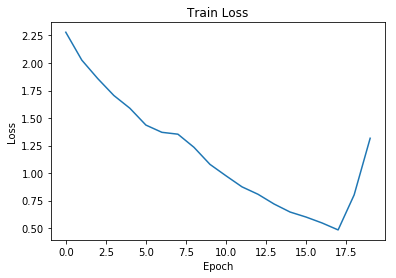

In [144]:
plt.plot(for_plot_loss)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Train Loss")
plt.show()

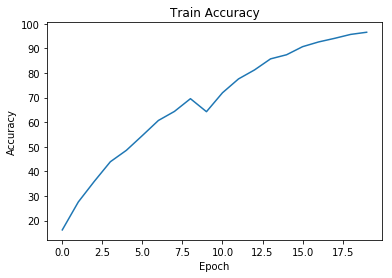

In [75]:
plt.plot(for_plot_acc)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Train Accuracy")
plt.show()